# STA208 Final Project

## Predicting Marine Organism Conservation Status

_________________
__Author:__ Evan Batzer 

__Date:__ 5/26/2020

### 0. Background

### 1. Assemblying Dataset

#### 1.1 Querying FishBase API

FishBase is a centralized database 

In [1]:
import requests
import pandas as pd
import numpy as np
from os import path
from plotnine import *
from sklearn.preprocessing import OneHotEncoder

def extract_fishbase(table):
    
    tablename = "https://fishbase.ropensci.org/" + table
    query = requests.get(tablename + "?limit=5000")
    n_obs = query.json()['count']
    df = pd.DataFrame(query.json()['data'])

    while(df.shape[0] < n_obs):
        query = requests.get(tablename + "?limit=5000&offset=" + str(df.shape[0]))
        tempdf = pd.DataFrame(query.json()['data'])
        df = df.append(tempdf)
        
    print("Table ''%s' - Returned %s rows of %s features" % (table, df.shape[0], df.shape[1]))  
    return(df)

In [2]:
# All available species
taxaTable = extract_fishbase("taxa")

# General species characteristics
speciesTable = extract_fishbase("species")

# Species ecology (habitat type, prey, etc.)
ecologyTable = extract_fishbase("ecology")

# Ecosystem characteristics
ecosystemTable = extract_fishbase("ecosystem")

# Maturity / reproduction
reproTable = extract_fishbase("maturity")

Table ''taxa' - Returned 34342 rows of 14 features
Table ''species' - Returned 34342 rows of 102 features
Table ''ecology' - Returned 11897 rows of 142 features
Table ''ecosystem' - Returned 151869 rows of 47 features
Table ''maturity' - Returned 8733 rows of 35 features


__Aggregating the ecosystem table:__ 

Rather than containing information on a species-by-species basis, the ecosystem table contains features that are organized by different habitats. Because models will be constructed at the species level (not subspecies or individual habitat), I aggregate these based on metric. Certain features are binary (present in freshwater/saltwater), so are converted to one-hot labels and summed per species -- some fish may be present in both types of water, for example. Others are summed or averaged, such as total range or average depth.

In [3]:
from sklearn.preprocessing import label_binarize

ecosys_cols = ["Speccode", "Salinity", "Area", "SizeRef", "Climate", "AverageDepth", "MaxDepth", "TempSurface", "TempDepth"]

ecosys_subset = ecosystemTable[ecosys_cols]

area_agg = ecosys_subset.groupby("Speccode")["Area"].sum()
ecosys_subset[["AverageDepth", "TempSurface", "TempDepth"]] = ecosys_subset[["AverageDepth", "TempSurface", "TempDepth"]].apply(pd.to_numeric, errors='coerce')
ATT_agg = ecosys_subset.groupby("Speccode")["AverageDepth", "TempSurface", "TempDepth"].mean()

ecosys_subset["Climate"] = ecosys_subset["Climate"].str.lower().fillna("None")
climate_onehot = label_binarize(ecosys_subset["Climate"], classes = ecosys_subset["Climate"].unique()[0:5])
climate_agg =  pd.DataFrame(climate_onehot, columns=ecosys_subset["Climate"].unique()[[0,1,2,3,4]])

ecosys_subset['Salinity'] = ecosys_subset['Salinity'].str.lower().fillna("None")
salinity_onehot = label_binarize(ecosys_subset['Salinity'], classes = ecosys_subset['Salinity'].unique()[0:3])
salinity_agg =  pd.DataFrame(salinity_onehot, columns=ecosys_subset['Salinity'].unique()[0:3])

cat_full = pd.DataFrame(ecosys_subset["Speccode"]).join([salinity_agg, climate_agg]).groupby('Speccode').sum()
cat_full = (cat_full > 1) * 1

ecosys_full = cat_full.join([area_agg, ATT_agg])
ecosys_full.reset_index(inplace = True)

C:\Users\ebatz\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\ebatz\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':
C:\Users\ebatz\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShe

Other tables contain considerable overlap in columns, particularly related to error checking or source material. Here, I subset each table to the relevant set of characteristics from each.

In [23]:
# Columns for the taxonomy dataset
taxa_cols = ["SpecCode", "Genus", "Species", "Family", "Order", "Class"]
taxa_subset = taxaTable[taxa_cols].set_index("SpecCode")

# Columns for the species dataset
spec_cols = ["SpecCode", "Vulnerability", "Length", "Weight", "Importance", "UsedforAquaculture",
             "UsedasBait", "Aquarium", "GameFish", "Dangerous"]

# Columns for the reproduction dataset
reproTable.rename(columns={"Speccode": "SpecCode"}, inplace = True)
repro_cols = ["SpecCode", "AgeMatMin", "AgeMatMin2", "LengthMatMin", "LengthMatMin2"]
repro_subset = reproTable[repro_cols].set_index("SpecCode")

repro_subset = repro_subset.groupby("SpecCode").mean()
AgeMin = repro_subset[["AgeMatMin","AgeMatMin2"]].min(axis = 1)
LengthMin = repro_subset[["LengthMatMin","LengthMatMin2"]].min(axis = 1)
repro_subset = pd.concat([pd.Series(AgeMin), pd.Series(LengthMin)],axis = 1)
repro_subset.columns = ["Age_Maturity", "Length_Maturity"]

# Columns for the ecology dataset
eco_cols = ["SpecCode","Neritic", "SupraLittoralZone", "Saltmarshes", "LittoralZone", "TidePools", "Intertidal", "SubLittoral", 
"Caves", "Oceanic","Epipelagic", "Mesopelagic", "Bathypelagic", "Abyssopelagic", "Hadopelagic", "Estuaries", "Mangroves",
"MarshesSwamps", "CaveAnchialine", "Stream", "Lakes","Cave",'DietTLu']

# Binaries are coded as -1,0 in this data - converting to 1,0
eco_subset = ecologyTable[eco_cols].set_index("SpecCode")
eco_subset[eco_cols[1:-1]] = (eco_subset[eco_cols[1:-1]] == -1) * 1
eco_subset = eco_subset.groupby("SpecCode").sum()

spec_subset = speciesTable[spec_cols]
spec_subset["GameFish"] = (speciesTable["GameFish"] == -1) * 1

# Binarizing labels
spec_bin = pd.concat(
    [pd.get_dummies(spec_subset["Importance"], prefix='Imp'),
     pd.get_dummies(spec_subset["Aquarium"], prefix='Aquarium'),
     pd.get_dummies(spec_subset["UsedforAquaculture"], prefix='Aquaculture'),
     pd.get_dummies(spec_subset["UsedasBait"], prefix='Bait').iloc[:,1:],
     pd.get_dummies(spec_subset["Dangerous"], prefix='Danger')],
    axis = 1)

spec_subset = pd.concat([spec_subset.drop(columns = ["Importance", "Aquarium", "UsedforAquaculture", "UsedasBait", "Dangerous"]),
           spec_bin],
          axis = 1).set_index("SpecCode")

C:\Users\ebatz\anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### 1.2 Joining Tables

In [24]:
features = taxa_subset.join([spec_subset, eco_subset, repro_subset, ecosys_full])
features.head()

,Genus,Species,Family,Order,Class,Vulnerability,Length,Weight,GameFish,Imp_,...,brackish,tropical,subtropical,polar,temperate,boreal,Area,AverageDepth,TempSurface,TempDepth
SpecCode,,,,,,,,,,,,,,,,,,,,,
48039,Abyssocottus,elochini,Abyssocottidae,Scorpaeniformes,Actinopterygii,40.29,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48040,Abyssocottus,gibbosus,Abyssocottidae,Scorpaeniformes,Actinopterygii,35.49,14.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47208,Abyssocottus,korotneffi,Abyssocottidae,Scorpaeniformes,Actinopterygii,32.97,12.6,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48048,Asprocottus,abyssalis,Abyssocottidae,Scorpaeniformes,Actinopterygii,38.21,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48049,Asprocottus,herzensteini,Abyssocottidae,Scorpaeniformes,Actinopterygii,33.02,11.5,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
features.to_csv("data/fishbase_features.csv")

#### 1.3 Creating IUCN Labels

In [26]:
if not path.exists('data/IUCN.csv'):

    try:
        from urllib.request import urlretrieve
    except ImportError:
        from urllib import urlretrieve

    urlretrieve('https://drive.google.com/u/0/uc?id=0B9_zEbZIPqtIVXJ1VVpEMGNxdnc&export=download', 
                'data/IUCN.csv')

# Reading in dataset -- correcting some encoding errors    
IUCN_labels = pd.read_csv('data/IUCN.csv', encoding = "ISO-8859-1", engine='python')

In [27]:
IUCN_labels = IUCN_labels[["Class", 'Order', 'Family', 'Genus', 'Species', 'Red List status']]

IUCN_labels[["Class", 'Order', 'Family']] = IUCN_labels[["Class", 'Order', 'Family']].apply(lambda x: x.astype(str).str.capitalize())
fish_classes = ['Actinopterygii', 'Chondrichthyes','Sarcopterygii','Cephalaspidomorphi']

IUCN_subset = IUCN_labels.loc[IUCN_labels['Class'].isin(fish_classes)]

IUCN_labels.head()

,Class,Order,Family,Genus,Species,Red List status
0,Magnoliopsida,Fabales,Leguminosae,Abarema,cochliocarpos,LC
1,Magnoliopsida,Fabales,Leguminosae,Abarema,commutata,LR/lc
2,Magnoliopsida,Fabales,Leguminosae,Abarema,curvicarpa,LC
3,Aves,Caprimulgiformes,Trochilidae,Abeillia,abeillei,LC
4,Mammalia,Rodentia,Muridae,Abeomelomys,sevia,LC


In [28]:
full_df = pd.merge(features, IUCN_subset.iloc[:,3:],  
         how='left', 
         left_on=['Genus', 'Species'], 
         right_on = ['Genus', 'Species'])

__Note:__ Some issues with taxonomy cause issues with the join. ~150 labels need to have corrected Genus/Species labels to match the current version of FishBase. Will have to correct manually later on.

In [29]:
data_labelled = full_df[full_df["Red List status"].notna()]
data_labelled.shape

(9268, 75)

Updated versions of the RedList dataset are not yet available for download. The data I am using is a few years old, and contains secondary categories between LC - "Least Concern" and NT - "Near Threatened" -- "LR/lc" and "LR/nt". There are relatively few observations of this class, so I'll just lump them into the LC class.

In [30]:
data_labelled["Red List status"] = data_labelled["Red List status"].str.replace("LR.+", "LC")
data_labelled["Red List status"] = pd.Categorical(data_labelled["Red List status"],
               categories = ["LC", "NT", "VU", "EN", "CR", "EW", "EX"],
              ordered=True)

C:\Users\ebatz\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\ebatz\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Removing species that are "endangered" or "extinct in the wild"

In [31]:
import numpy as np
data_labelled = data_labelled[~data_labelled["Red List status"].isin(["EX", "EW"])]
data_labelled.to_csv("data/data_labelled.csv")

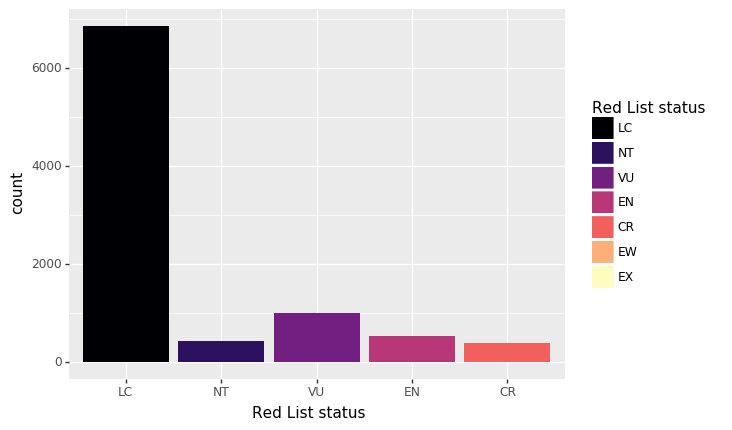

<ggplot: (-9223371924973087224)>

In [32]:
(ggplot(data_labelled,
       aes(x = 'Red List status',
          fill = 'Red List status')) + 
 geom_bar() +
scale_fill_cmap_d("magma"))

### 2. Imputing Missing Features

Ideally, imputation could be constructed using phylogenetic information from different species -- the genetic relationships that describe how similar species are to one another on an evolutionary scale. Given the scope of this dataset, however, a full *time-calibrated phylogeny of all fish species* is not available. 

However, many features are predictive of one another. Larger fish, for example, are likely to have longer times to maturity and slower reproductive rates. Approches like Random Forest based imputation are known to be [effective imputers for species trait data](https://besjournals.onlinelibrary.wiley.com/doi/10.1111/2041-210X.12232) in certain circumstances.

In [64]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

data_labelled = pd.read_csv("data/data_labelled.csv")

imputer = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=5),
                            add_indicator = True)

In [65]:
features = data_labelled.drop(["Species", "Vulnerability", "Red List status", "Genus", 
                               "Family", "Order", "Class", "Unnamed: 0", "Speccode"], axis = 1)
features["Area"].replace(0, np.nan, inplace=True)

In [66]:
features.columns

Index(['Length', 'Weight', 'GameFish', 'Imp_ ', 'Imp_commercial',
       'Imp_highly commercial', 'Imp_minor commercial', 'Imp_of no interest',
       'Imp_of potential interest', 'Imp_subsistence fisheries',
       'Aquarium_commercial', 'Aquarium_highly commercial',
       'Aquarium_never/rarely', 'Aquarium_potential',
       'Aquarium_public aquariums', 'Aquarium_show aquarium',
       'Aquaculture_commercial', 'Aquaculture_experimental',
       'Aquaculture_likely future use', 'Aquaculture_never/rarely',
       'Bait_never/rarely', 'Bait_occasionally', 'Bait_usually',
       'Danger_Harmless', 'Danger_harmless', 'Danger_other',
       'Danger_poisonous to eat', 'Danger_potential pest',
       'Danger_reports of ciguatera poisoning', 'Danger_traumatogenic',
       'Danger_venomous', 'Neritic', 'SupraLittoralZone', 'Saltmarshes',
       'LittoralZone', 'TidePools', 'Intertidal', 'SubLittoral', 'Caves',
       'Oceanic', 'Epipelagic', 'Mesopelagic', 'Bathypelagic', 'Abyssopelagic',
  

In [67]:
features_bin = pd.get_dummies(features, columns=[])
features_bin = features_bin.drop("Imp_ ", axis = 1)

In [68]:
features_bin.head()

,Length,Weight,GameFish,Imp_commercial,Imp_highly commercial,Imp_minor commercial,Imp_of no interest,Imp_of potential interest,Imp_subsistence fisheries,Aquarium_commercial,...,brackish,tropical,subtropical,polar,temperate,boreal,Area,AverageDepth,TempSurface,TempDepth
0,24.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,33.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,45.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,244296764.0,4100.0,20.05,17.375
3,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,85029540.0,3600.0,21.55,17.550


In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_std = pd.DataFrame(scaler.fit_transform(features_bin), columns = features_bin.columns)

In [70]:
data_imputed = imputer.fit_transform(features_std)

C:\Users\ebatz\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


### 3. Feature Engineering

### 4. Binary Classification - Threatened / Non-Threatened

In [79]:
x_full = data_imputed # Imputed predictors
y_full = data_labelled["Red List status"] == "LC" * 1 # Classes - whether "Least Concern" or not 

In [80]:
from xgboost import XGBRFClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [81]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 8, 10, 20],
        'n_estimators': [100,200,300,500,600,800,1000]
        }

xgb = XGBRFClassifier(learning_rate=0.02,
                    objective='binary:logistic',
                    silent=True, 
                    nthread=1)

folds = 3
param_comb = 25

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 0)

random_search = RandomizedSearchCV(xgb, param_distributions=params, 
                                   n_iter=param_comb, scoring='accuracy', n_jobs=4, 
                                   cv=skf.split(x_full,y_full), verbose=3, random_state=0)

In [82]:
random_search.fit(x_full, y_full)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  8.1min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001A0DA214DC8>,
                   error_score=nan,
                   estimator=XGBRFClassifier(base_score=0.5,
                                             colsample_bylevel=1,
                                             colsample_bynode=0.8,
                                             colsample_bytree=1, gamma=0,
                                             learning_rate=0.02,
                                             max_delta_step=0, max_depth=3,
                                             min_child_weight=1, missing=None,
                                             n_estimators=100, n_jobs=1,
                                             nthread=1,
                                             objective='binary:logistic',
                                             rando...
                                             subsample=0.8, verbosity=1),
                   iid='deprecated', n_iter=25, n_jobs=4,
      

In [95]:
best_est = random_search.best_estimator_

In [96]:
random_search.cv_results_['mean_test_score']

array([0.7584485 , 0.76681542, 0.75920908, 0.75996983, 0.75670992,
       0.75855726, 0.76627211, 0.76312081, 0.75877456, 0.77061844,
       0.76724988, 0.76333839, 0.76583713, 0.76377313, 0.76322967,
       0.7577964 , 0.76192596, 0.7636643 , 0.75931762, 0.76746735,
       0.75996965, 0.76214305, 0.76225176, 0.75605795, 0.75703593])

In [112]:
best_est.fit(x_full, y_full)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=0.6, gamma=1, learning_rate=0.02,
                max_delta_step=0, max_depth=20, min_child_weight=1,
                missing=None, n_estimators=600, n_jobs=1, nthread=1,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
                subsample=0.6, verbosity=1)

In [105]:
best_est.score(x_full, y_full)

0.8114745191785288

In [106]:
best_comp = random_search.best_estimator_
best_comp.fit(features_std, y_full)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=0.6, gamma=1, learning_rate=0.02,
                max_delta_step=0, max_depth=20, min_child_weight=1,
                missing=None, n_estimators=600, n_jobs=1, nthread=1,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
                subsample=0.6, verbosity=1)

In [107]:
best_comp.score(features_std, y_full)

0.7950668260349886

In [113]:
best_est.feature_importances_.shape

(104,)

In [116]:
imputed_cols = features_std.columns.append(features_std.columns[features_std.isnull().any()] + "Missing")

var_imp = pd.concat([pd.Series(best_est.feature_importances_),
             pd.Series(imputed_cols)],axis = 1)
var_imp.columns=["importance", "variable"]
var_imp.sort_values('importance')

,importance,variable
80,0.000000,AbyssopelagicMissing
32,0.000000,Saltmarshes
31,0.000000,SupraLittoralZone
56,0.000000,brackish
60,0.000000,temperate
...,...,...
93,0.031113,saltwaterMissing
97,0.032726,polarMissing
92,0.032858,freshwaterMissing
96,0.033053,subtropicalMissing


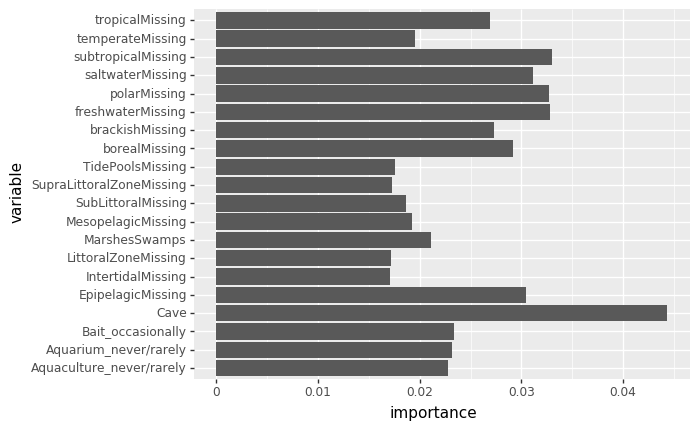

<ggplot: (-9223371924967362988)>

In [115]:
(ggplot(aes(y = 'importance',
            x = 'variable'),
       var_imp.sort_values('importance').iloc[-20:,]) +
 geom_bar(stat = "identity") +
 coord_flip())

### 5. Ordinal Classification - Conservation Status as a pseudo-numeric scale

### 6. Predicting Unlabelled Observations

#### 6.1 Comparison with other methods